# Data fetching

In [10]:
import yfinance as yf
import pandas as pd

ticker = "MSFT"
start_date = "2015-01-01"
end_date = "2024-12-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)


df.columns=['Close','High','Low','Open','Volume']
print(df)

                 Close        High         Low        Open    Volume
Date                                                                
2015-01-02   39.858448   40.421035   39.670921   39.773209  27913900
2015-01-05   39.491924   39.832884   39.423730   39.526018  39673900
2015-01-06   38.912292   39.849937   38.818527   39.534548  36447900
2015-01-07   39.406681   39.602734   38.775903   39.193580  29114100
2015-01-08   40.565948   40.702333   39.824357   39.849928  29645200
...                ...         ...         ...         ...       ...
2024-12-23  432.062775  434.445194  429.660482  433.541854  19152500
2024-12-24  436.112854  436.380896  431.010509  431.467132   7164500
2024-12-26  434.901825  437.711119  433.432682  435.864723   8194200
2024-12-27  427.377319  432.032978  423.227936  431.417523  18117700
2024-12-30  421.719055  424.419138  418.810518  422.940059  13158700

[2515 rows x 5 columns]


/tmp/ipython-input-1410272507.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


#Feature Engineering

In [11]:
import numpy as np

In [12]:
window_size = 7

df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

for lag in range(1, window_size + 1):
    df[f'Log_Return_Lag_{lag}'] = df['Log_Return'].shift(lag)

df['MA_7'] = df['Close'].rolling(window=window_size).mean()
df['Volatility_7'] = df['Log_Return'].rolling(window=window_size).std()
df['Price_ROC_7'] = df['Close'].pct_change(periods=window_size)
df['Momentum_7'] = df['Close'] - df['Close'].shift(window_size)
df['Volume_ROC_7'] = df['Volume'].pct_change(periods=window_size)
df['Close_to_Open'] = df['Close'] / df['Open']
df['High_to_Low'] = df['High'] / df['Low']

df.dropna(inplace=True)

print(f"Data shape after feature engineering: {df.shape}")
print(df.head())
print("*****************************************************************************")
print(df.info())

Data shape after feature engineering: (2507, 20)
                Close       High        Low       Open    Volume  Log_Return  \
Date                                                                           
2015-01-14  39.176540  39.415216  38.886722  39.176540  29719600   -0.008665   
2015-01-15  38.767368  39.534534  38.707700  39.398149  32750800   -0.010499   
2015-01-16  39.415218  39.449312  38.503142  38.622481  35695300    0.016573   
2015-01-20  39.543056  39.764684  38.844085  39.466340  36161900    0.003238   
2015-01-21  39.142437  39.329967  38.767380  39.159485  39081100   -0.010183   

            Log_Return_Lag_1  Log_Return_Lag_2  Log_Return_Lag_3  \
Date                                                               
2015-01-14         -0.005164         -0.012581         -0.008441   
2015-01-15         -0.008665         -0.005164         -0.012581   
2015-01-16         -0.010499         -0.008665         -0.005164   
2015-01-20          0.016573         -0.010499    

#Kalman filter model

In [13]:
!pip install pykalman

In [14]:
from pykalman import KalmanFilter

feature_cols = [col for col in df.columns if col not in ['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return']]
target = df['Log_Return'].values

obs_matrices = df[feature_cols].values.reshape(-1, 1, len(feature_cols))

n_dim_obs = 1
n_dim_state = len(feature_cols)

kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.eye(n_dim_state),
    transition_matrices=np.eye(n_dim_state),
    observation_matrices=obs_matrices,
    observation_covariance=1.0,
    transition_covariance=np.eye(n_dim_state) * 0.01
)

state_means, state_covariances = kf.filter(target)
df2=pd.DataFrame()

for i, col in enumerate(feature_cols):
    df2[f'KF_State_{col}'] = state_means[:, i]

print("Kalman Filter extraction complete.")
print("Shape of State Means:", state_means.shape)
print(df2.head())

Kalman Filter extraction complete.
Shape of State Means: (2507, 14)
   KF_State_Log_Return_Lag_1  KF_State_Log_Return_Lag_2  \
0               2.840814e-08               6.921788e-08   
1               4.014263e-07              -6.935463e-07   
2              -2.846350e-06              -5.602100e-06   
3              -1.990089e-05              -4.274798e-06   
4              -1.005885e-05              -2.670107e-05   

   KF_State_Log_Return_Lag_3  KF_State_Log_Return_Lag_4  \
0               4.643809e-08              -1.595133e-07   
1               4.902129e-07               3.730037e-06   
2               1.142062e-05              -5.748142e-06   
3               1.342853e-05              -9.880601e-06   
4               1.522076e-05              -7.285166e-06   

   KF_State_Log_Return_Lag_5  KF_State_Log_Return_Lag_6  \
0              -6.945946e-08               8.134763e-08   
1              -1.799655e-06              -2.774264e-06   
2              -5.787210e-05               2.

#Modelling LSTM

In [15]:
df['Future_Ratio'] = df['Close'].shift(-1) / df['Close']

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


def create_sequences(data, target, time_steps=10):
    Xs, ys = [], []
    for i in range(len(data) - time_steps - 1):
        Xs.append(data[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
target = df['Future_Ratio'].values


split_idx = int(len(df2) * 0.8)
train_data = df2.values[:split_idx]
test_data = df2.values[split_idx:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

X_train, y_train = create_sequences(train_data, target, time_steps)
X_test, y_test = create_sequences(test_data, target, time_steps)

print(f"LSTM Input Shape: {X_train.shape}")

model = Sequential()

# Layer 1: LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Prevents overfitting

#Layer 2 : LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

#Layer 3: LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Prevents overfitting

# Layer 3: Dense (Output)
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
test_preds = test_preds.flatten()

LSTM Input Shape: (1994, 10, 14)
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.4115 - val_loss: 0.0047
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0102 - val_loss: 2.4320e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0078 - val_loss: 7.7113e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0076 - val_loss: 3.1221e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0067 - val_loss: 4.3007e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 3.9774e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - val_loss: 3.2712e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


#Decision making

In [28]:
test_df_start_index = split_idx + time_steps
test_df = df.iloc[test_df_start_index : test_df_start_index + len(test_preds)].copy()

test_df['Predicted_Ratio'] = test_preds
window = 20
test_df['Model_Baseline'] = test_df['Predicted_Ratio'].rolling(window=window).mean()
test_df['Model_Std'] = test_df['Predicted_Ratio'].rolling(window=window).std()

z_score_threshold = 1.5

test_df['Signal'] = np.where(
    test_df['Predicted_Ratio'] > (test_df['Model_Baseline'] + z_score_threshold * test_df['Model_Std']), 1,
    np.where(test_df['Predicted_Ratio'] < (test_df['Model_Baseline'] - z_score_threshold * test_df['Model_Std']), -1, 0)
)
test_df['Signal'] = test_df['Signal'].fillna(0)

print(test_df['Signal'].value_counts())

Signal
0    271
1    220
Name: count, dtype: int64


#Portfolio Analysis

In [29]:
initial_capital = 10000
cash = initial_capital
shares = 0
portfolio_values = []
transaction_cost = 0.001

for index, row in test_df.iterrows():
    price = row['Close']
    signal = row['Signal']

    if signal == 1:
        if shares < 0:
            cost_to_cover = abs(shares) * price
            cash -= (cost_to_cover + (cost_to_cover * transaction_cost))
            shares = 0

        if shares == 0:
            available_cash = cash
            max_shares = int(available_cash / (price * (1 + transaction_cost)))
            if max_shares > 0:
                cost = max_shares * price
                cash -= (cost + (cost * transaction_cost))
                shares += max_shares

    elif signal == -1:
        if shares > 0:
            proceeds = shares * price
            cash += (proceeds - (proceeds * transaction_cost))
            shares = 0

        if shares == 0:
            equity = cash
            max_short_shares = int(equity / (price * (1 + transaction_cost)))
            if max_short_shares > 0:
                proceeds = max_short_shares * price
                cash += (proceeds - (proceeds * transaction_cost))
                shares -= max_short_shares

    current_val = cash + (shares * price)
    portfolio_values.append(current_val)

test_df['Portfolio_Value'] = portfolio_values
print(test_df[['Close', 'Signal', 'Portfolio_Value']].head())
print(test_df[['Close', 'Signal', 'Portfolio_Value']].tail())

                 Close  Signal  Portfolio_Value
Date                                           
2023-01-17  234.737656       0          10000.0
2023-01-18  230.303665       0          10000.0
2023-01-19  226.514267       0          10000.0
2023-01-20  234.610718       0          10000.0
2023-01-23  236.915604       0          10000.0
                 Close  Signal  Portfolio_Value
Date                                           
2024-12-20  433.402893       0     16221.675095
2024-12-23  432.062775       0     16172.090714
2024-12-24  436.112854       0     16321.943650
2024-12-26  434.901825       0     16277.135575
2024-12-27  427.377319       0     15998.728867


#Backtesting

Strategy Cumulative Return: 59.99%
Benchmark Cumulative Return: 82.07%
Sharpe Ratio: 1.26
Maximum Drawdown: -15.32%
Win/Loss Ratio (Daily): 1.20


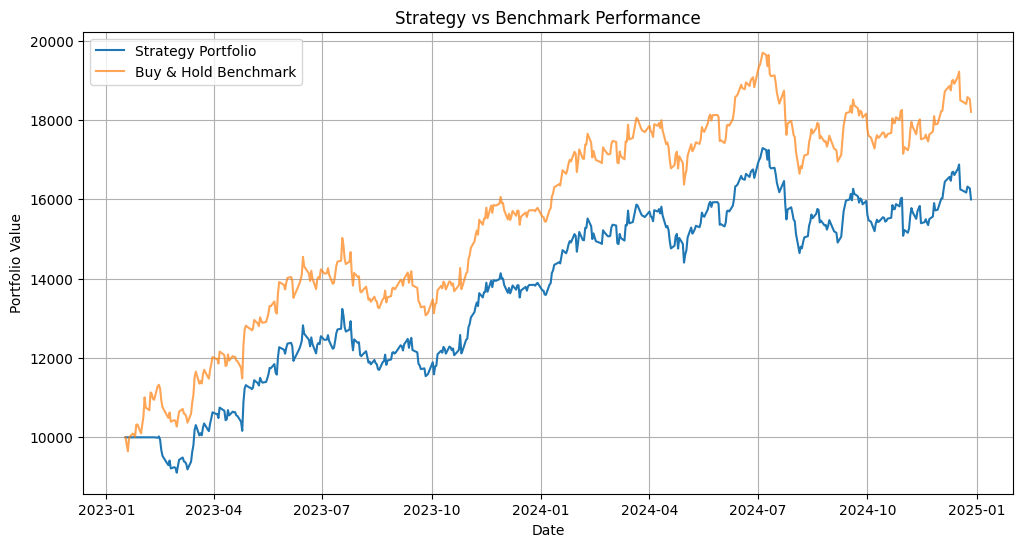

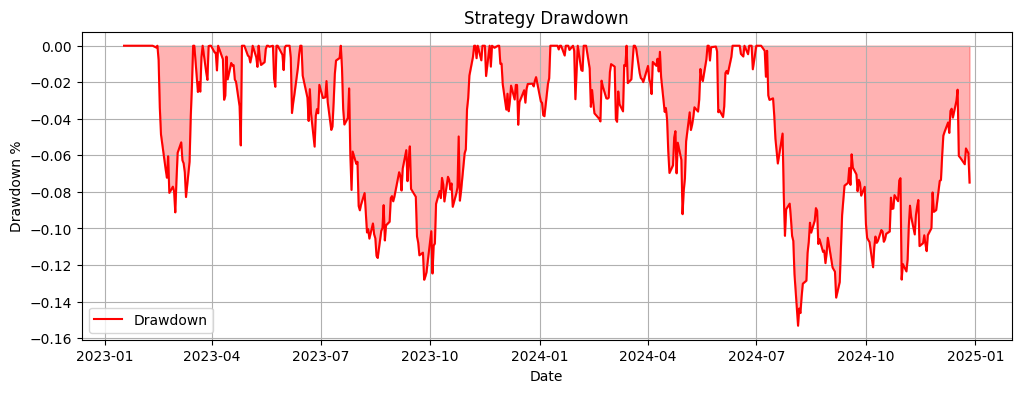

In [31]:
import matplotlib.pyplot as plt

test_df['Strategy_Returns'] = test_df['Portfolio_Value'].pct_change()
test_df['Benchmark_Returns'] = test_df['Close'].pct_change()

cumulative_strategy_return = (test_df['Portfolio_Value'].iloc[-1] / test_df['Portfolio_Value'].iloc[0]) - 1
cumulative_benchmark_return = (test_df['Close'].iloc[-1] / test_df['Close'].iloc[0]) - 1

sharpe_ratio = (test_df['Strategy_Returns'].mean() / test_df['Strategy_Returns'].std()) * np.sqrt(252)

rolling_max = test_df['Portfolio_Value'].cummax()
drawdown = (test_df['Portfolio_Value'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

winning_days = len(test_df[test_df['Strategy_Returns'] > 0])
losing_days = len(test_df[test_df['Strategy_Returns'] < 0])
win_loss_ratio = winning_days / losing_days if losing_days > 0 else float('inf')

print(f"Strategy Cumulative Return: {cumulative_strategy_return:.2%}")
print(f"Benchmark Cumulative Return: {cumulative_benchmark_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Win/Loss Ratio (Daily): {win_loss_ratio:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['Portfolio_Value'], label='Strategy Portfolio')
plt.plot(test_df.index, test_df['Close'] / test_df['Close'].iloc[0] * initial_capital, label='Buy & Hold Benchmark', alpha=0.7)
plt.title('Strategy vs Benchmark Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(test_df.index, drawdown, color='red', label='Drawdown')
plt.fill_between(test_df.index, drawdown, color='red', alpha=0.3)
plt.title('Strategy Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown %')
plt.legend()
plt.grid(True)
plt.show()